In [83]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
resolution = '3h'
tscale = 24

In [59]:
data_dir = os.path.join('..','data','tmpa_conus_data','data_tmpa_3h_cut_upscale.nc')

DATA = xr.open_dataset(data_dir)

lons = DATA.lon.values
lats = DATA.lat.values

lon2d_ref, lat2d_ref = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

ntime = len(DATA['time'])

print(dx)
print(dy)

DATA

0.5
0.5


<xarray.Dataset> Size: 487kB
Dimensions:  (time: 2433, lon: 8, lat: 6)
Coordinates:
  * time     (time) datetime64[ns] 19kB 2008-01-01 ... 2018-10-31T21:00:00
  * lon      (lon) float64 64B -93.75 -93.25 -92.75 ... -91.25 -90.75 -90.25
  * lat      (lat) float64 48B 31.25 31.75 32.25 32.75 33.25 33.75
Data variables:
    PRE      (time, lat, lon) float32 467kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  TMPA 3h
    history:      Thu Jul 25 18:17:25 2024: cdo gridboxmean,2,2 data_tmpa_3h_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [4]:
lat_d = []
for i in range(0,nlat_ref-1):
    lat_tmp = lats[i] + ((lats[i+1] - lats[i])/2)
    lat_d.append(lat_tmp)

lon_d = []
for i in range(0,nlon_ref-2):
    lon_tmp = lons[i] + ((lons[i+1] - lons[i])/2)
    lon_d.append(lon_tmp)

lon2d_d, lat2d_d = np.meshgrid(lon_d, lat_d)
nlat = len(lat_d)
nlon = len(lon_d)

In [58]:
np.mean(DATA['PRE'].values,axis=0).shape

(6, 8)

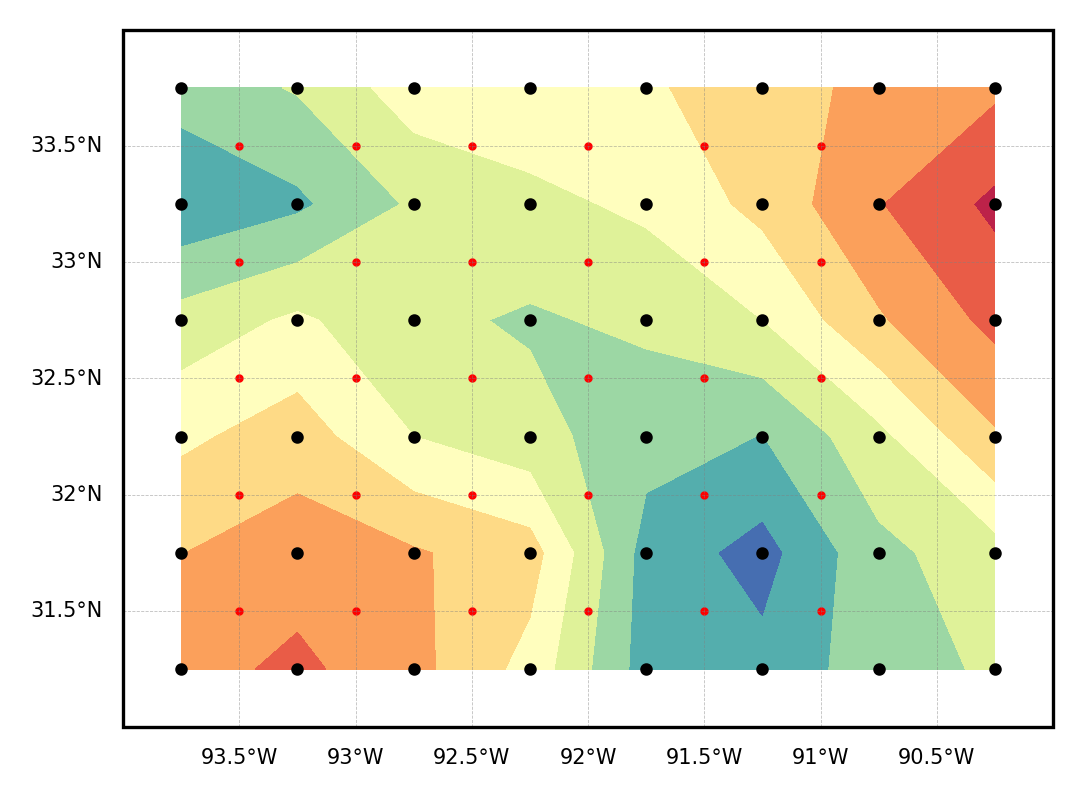

In [5]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d, lat2d, np.mean(DATA['PRE'].values,axis=0), cmap=cmap)
ax1.scatter(lon2d, lat2d, s=4, c='k')
ax1.scatter(lon2d_d, lat2d_d, s=1, c='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [6]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3
Tr = np.array([10, 20, 50, 100])
nyears = len(Tr)

In [7]:
MEV_d_matrix = np.zeros([nyears, nlat, nlon])
MEV_s_matrix = np.zeros([nyears, nlat, nlon])
NYs_matrix = np.zeros([nlat, nlon])
CYs_matrix = np.zeros([nlat, nlon])
WYs_matrix = np.zeros([nlat, nlon])
NYd_matrix = np.zeros([nlat, nlon])
CYd_matrix = np.zeros([nlat, nlon])
WYd_matrix = np.zeros([nlat, nlon])
Nd_matrix = np.zeros([nlat, nlon])
Cd_matrix = np.zeros([nlat, nlon])
Wd_matrix = np.zeros([nlat, nlon])
Ns_matrix = np.zeros([nlat, nlon])
Cs_matrix = np.zeros([nlat, nlon])
Ws_matrix = np.zeros([nlat, nlon])
eps_s_matrix = np.zeros([nlat, nlon])
alp_s_matrix = np.zeros([nlat, nlon])
eps_d_matrix = np.zeros([nlat, nlon])
alp_d_matrix = np.zeros([nlat, nlon])
gam_d_matrix = np.zeros([nlat, nlon])
gam_s_matrix = np.zeros([nlat, nlon])
beta_matrix = np.zeros([nlat, nlon])
QUANTILE = np.zeros([ntime, nlat, nlon])
RAIN_D = np.zeros([ntime, nlat, nlon])

L0 = 0.005 # 0.5 degrees
npix = 3

count = 0
for i in range(nlat):
    for j in range(nlon):
        clat = lat2d_d[i,j]
        clon = lon2d_d[i,j]
        L1 = down.area_lat_long(clat, clon, dy, dx)[0] # in Km
        
        tmpalat = DATA['lat'][:]
        tmpalon = DATA['lon'][0:7]
        dates = DATA['time'][:]
        dset = np.swapaxes(DATA['PRE'],0,2).data[0:7,:,:]
        x = da.from_array(dset, chunks=(6, 6, 300))
        xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                            dims=('lon', 'lat', 'time'))
        xrs = xrs0.where(xrs0 >= -0.001)

        buffer = 0.50*npix*dx
        eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
        solat = clat - buffer + eps
        nolat = clat + buffer + eps
        ealon = clon + buffer + eps
        welon = clon - buffer + eps
        bcond = np.logical_and(
                    np.logical_and( xrs.lat > solat, xrs.lat < nolat),
                    np.logical_and( xrs.lon > welon, xrs.lon < ealon))

        box_3h = xrs.where(bcond, drop = True).load()
        
        downres = down.downscale(box_3h, Tr, thresh=thresh, L0=50, toll=toll,
                                acf=acf, save_yearly=True,
                                maxmiss=300, clat=clat, clon=clon,
                                opt_method=opt_method, plot=False)
        
        MEV_d_matrix[:,i,j] = downres['mev_d']
        MEV_s_matrix[:,i,j] = downres['mev_s']
        NYs_matrix[i,j] = downres['NYs']
        CYs_matrix[i,j] = downres['CYs']
        WYs_matrix[i,j] = downres['WYs']
        NYd_matrix[i,j] = downres['NYd']
        CYd_matrix[i,j] = downres['CYd']
        WYd_matrix[i,j] = downres['WYd']
        Nd_matrix[i,j] = downres['Nd']
        Cd_matrix[i,j] = downres['Cd']
        Wd_matrix[i,j] = downres['Wd']
        Ns_matrix[i,j] = downres['Ns']
        Cs_matrix[i,j] = downres['Cs']
        Ws_matrix[i,j] = downres['Ws']
        eps_s_matrix[i,j] =downres['eps_s'] 
        alp_s_matrix[i,j] = downres['alp_s']
        eps_d_matrix[i,j] = downres['eps_d']
        alp_d_matrix[i,j] = downres['alp_d']
        gam_d_matrix[i,j] = downres['gam_d']
        gam_s_matrix[i,j] = downres['gam_s']
        beta_matrix[i,j] = downres['beta']
        
        Tr_test = np.linspace(1,100,box_3h.shape[2])
        Fi2 = 1 - 1/Tr_test
        qq = down.mev_quant(Fi2, 1, downres['Nd'], downres['Cd'], downres['Wd'], thresh=1)[0]
        QUANTILE[:,i,j] = qq/np.nanmax(qq)
        
        RAIN_D[:,i,j] = box_3h[1,1,:].data * qq/np.nanmax(qq)

Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.012286080608304559
differential_evolution step 2: f(x)= 0.012205666274635112
differential_evolution step 3: f(x)= 0.012099687844545591
differential_evolution step 4: f(x)= 0.012026799032997857
differential_evolution step 5: f(x)= 0.012026799032997857
differential_evolution step 6: f(x)= 0.012026799032997857
differential_evolution step 7: f(x)= 0.012026799032997857
differential_evolution step 8: f(x)= 0.012026799032997857
differential_evolution step 9: f(x)= 0.012026799032997857
Polishing solution with 'L-BFGS-B'
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters
Downscaling Intermittency
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.007603816822530548
differential_evolution step 2: f(x)= 0.006835201389735539
differential_evolution step 3: f(x)= 0.005972745101196885
differential_evolutio

In [126]:
DOWN_xr = xr.Dataset(data_vars={
                "MEV_d": (("year","lat","lon"), MEV_d_matrix),
                "MEV_s": (("year","lat","lon"), MEV_s_matrix),
                "NYs": (("lat","lon"),NYs_matrix ),
                "CYs": (("lat","lon"),CYs_matrix ),
                "WYs": (("lat","lon"),WYs_matrix ),
                "NYd": (("lat","lon"),NYd_matrix ),
                "CYd": (("lat","lon"),CYd_matrix ),
                "WYd": (("lat","lon"),WYd_matrix ),
                "Nd": (("lat","lon"),Nd_matrix ),
                "Cd": (("lat","lon"),Cd_matrix ),
                "Wd": (("lat","lon"),Wd_matrix ),
                "Ns": (("lat","lon"),Ns_matrix ),
                "Cs": (("lat","lon"),Cs_matrix ),
                "Ws": (("lat","lon"),Ws_matrix ),
                "eps_s": (("lat","lon"),eps_s_matrix ),
                "alp_s": (("lat","lon"),alp_s_matrix ),
                "eps_d": (("lat","lon"),eps_d_matrix ),
                "alp_d": (("lat","lon"),alp_d_matrix ),
                
                "gam_d": (("lat","lon"),gam_d_matrix ),
                "gam_s": (("lat","lon"),gam_s_matrix ),
                "bet": (("lat","lon"),beta_matrix ),
                
                "Fi": (("time"),Fi2 ),
                "QUANTILE": (("time","lat","lon"),QUANTILE ),
                "RAIN_D": (("time","lat","lon"),RAIN_D ),
                },
                    coords={'year': Tr, 'time': DATA['time'],'lat': lat_d, 'lon': lon_d},
                    attrs=dict(description="Dowscalling test"))

DOWN_xr.MEV_d.attrs["standard_name"] = "Single quantile, or array of quantiles downscale Weibull parameters"
DOWN_xr.MEV_s.attrs["standard_name"] = "Single quantile, or array of quantiles global Weibull parameters"

DOWN_xr.NYs.attrs["standard_name"] = "Dimension parameter of Yearly MEV distribution"
DOWN_xr.CYs.attrs["standard_name"] = "Scale parameter of Yearly MEV distribution"
DOWN_xr.WYs.attrs["standard_name"] = "Shape parameter of Yearly MEV distribution"

DOWN_xr.NYd.attrs["standard_name"] = "Dimension parameter of downscale Yearly MEV distribution"
DOWN_xr.CYd.attrs["standard_name"] = "Scale parameter of downscale Yearly MEV distribution"
DOWN_xr.WYd.attrs["standard_name"] = "Shape parameter of downscale Yearly MEV distribution"

DOWN_xr.Nd.attrs["standard_name"] = "Dimension parameter of downscale global MEV distribution"
DOWN_xr.Cd.attrs["standard_name"] = "Scale parameter of downscale global MEV distribution"
DOWN_xr.Wd.attrs["standard_name"] = "Shape parameter of downscale global MEV distribution"

DOWN_xr.Ns.attrs["standard_name"] = "Dimension parameter of global MEV distribution"
DOWN_xr.Cs.attrs["standard_name"] = "Scale parameter of global MEV distribution"
DOWN_xr.Ws.attrs["standard_name"] = "Shape parameter of global MEV distribution"

DOWN_xr.eps_s.attrs["standard_name"] = "parameters of the correlation function at the pixel scale (d0_s)"
DOWN_xr.alp_s.attrs["standard_name"] = "parameters of the correlation function at the pixel scale (mu0_s)"

DOWN_xr.eps_d.attrs["standard_name"] = "parameters of the correlation function downscaled at scale L0 (d0_d)"
DOWN_xr.alp_d.attrs["standard_name"] = "parameters of the correlation function downscaled at scale L0 (mu0_d)"

DOWN_xr.gam_d.attrs["standard_name"] = "variance reduction function global"
DOWN_xr.gam_s.attrs["standard_name"] = "variance reduction function downscale"
DOWN_xr.bet.attrs["standard_name"] = "wet fraction reduction function between the two scale"

DOWN_xr.Fi.attrs["units"] = "Non exceedance probability"
DOWN_xr.QUANTILE.attrs["long_name"] = "Single quantile, or array of quantiles"
DOWN_xr.RAIN_D.attrs["long_name"] = "The product of QUANTILES and nearest rainfall series"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [127]:
DOWN_xr

<xarray.Dataset> Size: 1MB
Dimensions:   (year: 4, lat: 5, lon: 6, time: 2433)
Coordinates:
  * time      (time) datetime64[ns] 19kB 2008-01-01 ... 2018-10-31T21:00:00
  * year      (year) int64 32B 10 20 50 100
  * lat       (lat) float64 40B 31.5 32.0 32.5 33.0 33.5
  * lon       (lon) float64 48B -93.5 -93.0 -92.5 -92.0 -91.5 -91.0
Data variables: (12/24)
    MEV_d     (year, lat, lon) float64 960B 197.6 173.3 148.7 ... 201.7 201.6
    MEV_s     (year, lat, lon) float64 960B 197.2 172.9 148.3 ... 201.1 201.1
    NYs       (lat, lon) float64 240B 107.0 102.0 101.0 96.0 ... 101.0 88.0 88.0
    CYs       (lat, lon) float64 240B 8.442 9.645 10.21 ... 9.913 12.81 12.81
    WYs       (lat, lon) float64 240B 0.6151 0.6693 0.7216 ... 0.8026 0.8026
    NYd       (lat, lon) float64 240B 107.0 102.0 101.0 96.0 ... 101.0 88.0 88.0
    ...        ...
    gam_d     (lat, lon) float64 240B 0.9977 0.9972 0.9973 ... 0.997 0.9975
    gam_s     (lat, lon) float64 240B 0.9982 0.9983 0.9983 ... 0.9985 0.9985
    bet       (lat, lon) float64 240B 1.002 1.003 1.003 ... 1.002 1.002 1.002
    Fi        (time) float64 19kB 0.0 0.03911 0.07529 0.1088 ... 0.99 0.99 0.99
    QUANTILE  (time, lat, lon) float64 584kB 0.003131 0.003727 ... 1.0 1.0
    RAIN_D    (time, lat, lon) float64 584kB 0.0 0.0 0.0 0.0 ... 2.638 0.0 0.0
Attributes:
    description:  Dowscalling test

In [128]:
DOWN_out = os.path.join('..','data','down_test','TEST_DOWN_PARAMETERS_05_025_3h.nc')
print(f'Export PRE data to {DOWN_out}')
DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to ../data/down_test/TEST_DOWN_PARAMETERS_05_025_3h.nc


In [52]:
lon2d, lat2d = np.meshgrid(DOWN_xr['lon'], DOWN_xr['lat'])

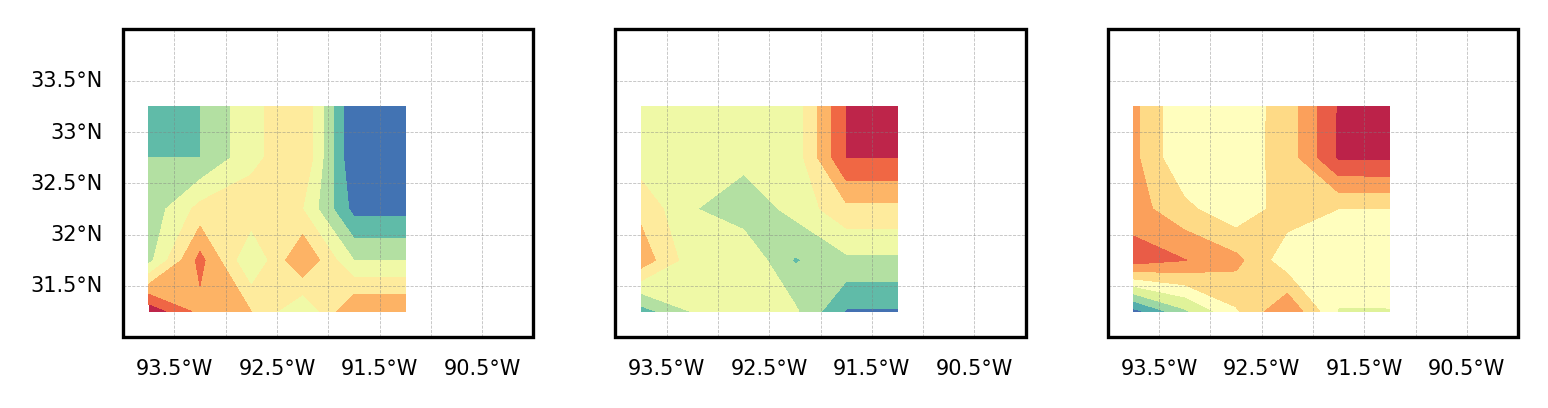

In [53]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,5),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(lon2d,  lat2d, DOWN_xr.Nd, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(lon2d,  lat2d, DOWN_xr.Cs, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(lon2d,  lat2d, DOWN_xr.Wd, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

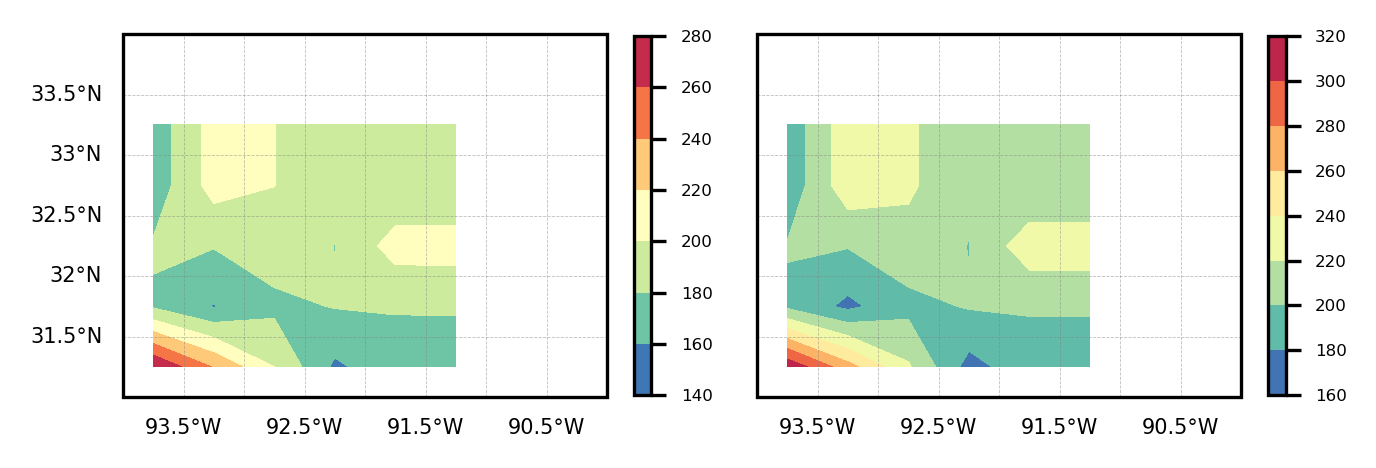

In [78]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d,  lat2d, DOWN_xr['MEV_d'][2,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=4)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d,  lat2d, DOWN_xr['MEV_s'][3,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=4)

In [123]:
lon_tets, lat_test = np.meshgrid(lon_d, lat_d)
lon_max, lon_min, lat_max, lat_min = np.max(lon_d), np.min(lon_d), np.max(lat_d), np.min(lat_d)

In [124]:
cropped_ds = DATA.sel(lat=slice(31.75, 33.25), lon=slice(-93.25, -91.25))
lon2d_ref, lat2d_ref = np.meshgrid(cropped_ds['lon'], cropped_ds['lat'])
cropped_ds

<xarray.Dataset> Size: 214kB
Dimensions:  (time: 2433, lon: 5, lat: 4)
Coordinates:
  * time     (time) datetime64[ns] 19kB 2008-01-01 ... 2018-10-31T21:00:00
  * lon      (lon) float64 40B -93.25 -92.75 -92.25 -91.75 -91.25
  * lat      (lat) float64 32B 31.75 32.25 32.75 33.25
Data variables:
    PRE      (time, lat, lon) float32 195kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  TMPA 3h
    history:      Thu Jul 25 18:17:25 2024: cdo gridboxmean,2,2 data_tmpa_3h_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

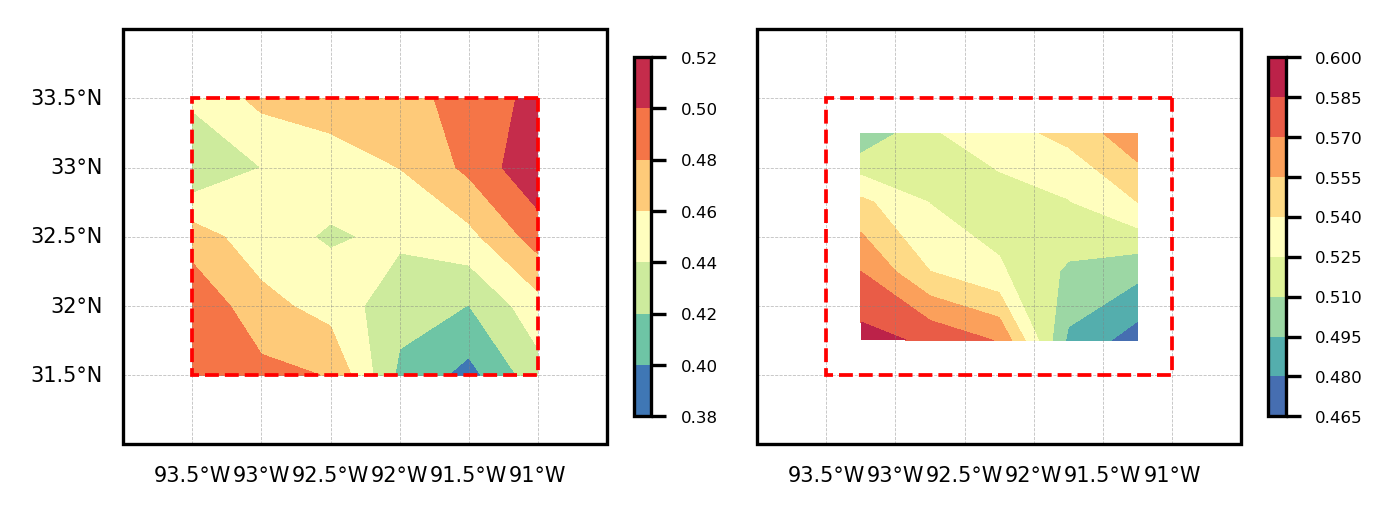

In [125]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([-94, -90.5, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon_tets, lat_test, np.nanmean(RAIN_D,axis=0), cmap=cmap)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=4)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-94, -90.5, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.mean(cropped_ds['PRE'].values,axis=0), cmap=cmap)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=4)